# SageMaker DeepAR Forecasting Project # 

This notebook will detail the data preprocessing, training and the obtaining of results for a DeepAR forecasting model for national cases of COVID-19. 

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from copy import copy

**Preprocessing**

Firstly, read in the transmission factors data from the current directory

In [4]:
df = pd.read_csv('transmission_factors.csv', header=0)
df.head()

,Country,Island (Y/N),Landlocked (Y/N),Annual International Tourist Arrivals,Average elevation above sea level (m),Urban population percentage,Air pollution Index,Population area density (/km),Average household size,Ethnic fractionalisation,...,Lockdown 2 End,Pop. Proportion 2,Lockdown 3 Start,Lockdown 3 End,Pop. Proportion 3,Asian Response Start,Asian Response End,TB Start,TB End,Population
0,Afghanistan,0,1,500000,1885.0,25,93.45,49.0,8.0,0.7693,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37000000
1,Albania,0,0,4070000,708.0,60,77.77,100.0,3.7,0.2204,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-15,NaN,2800000
2,Algeria,0,0,2039000,800.0,73,65.75,18.0,4.5,0.3394,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-20,NaN,42000000
3,Andorra,0,1,2831000,1996.0,88,43.00,164.0,2.1,0.7139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77000
4,Angola,0,0,397000,1112.0,66,70.00,23.0,4.8,0.7867,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31000000


Next, split the data into the static and the temporal variables

In [5]:
static_df = df.iloc[:, :20]
time_df = df.iloc[:, 20:]

The static variables statistics should be inspected for imbalances in the data. The means for the annual tourist arrivals and population density variables are very low in relation to their max value, and so these will be further investigated.

In [6]:
static_df.describe()

,Island (Y/N),Landlocked (Y/N),Annual International Tourist Arrivals,Average elevation above sea level (m),Urban population percentage,Air pollution Index,Population area density (/km),Average household size,Ethnic fractionalisation,Linguistic fractionalisation,Religious fractionalisation,GDP per Capita,Infant Mortality Rate (Deaths per 1000 Births),Annual Cigarette Consumption per Capita,Proportion of Population Using Cannabis,Obesity Rate,Corruption Perception Index,Crime Index,Water and Sanitation Rating
count,182.000000,182.000000,1.820000e+02,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000
mean,0.203297,0.280220,6.421584e+06,551.454945,60.109890,57.979121,307.275275,3.830769,0.452543,0.384483,0.426372,24363.939560,20.730769,909.592857,4.648429,16.892308,43.956044,47.865824,57.362747
std,0.403562,0.450345,1.304241e+07,557.708150,22.815353,19.403864,1524.935773,1.306862,0.255299,0.291798,0.235855,25143.695977,19.502345,899.582071,5.122714,9.820283,18.762495,15.970892,13.097053
min,0.000000,0.000000,1.000000e+04,1.800000,13.000000,11.550000,1.900000,1.900000,0.000000,0.000000,0.000000,724.000000,1.000000,9.700000,0.004000,5.000000,9.000000,12.000000,27.430000
25%,0.000000,0.000000,2.735000e+05,173.500000,42.250000,44.880000,32.500000,2.725000,0.220700,0.105250,0.212400,6055.000000,5.000000,282.375000,1.250000,5.000000,29.250000,36.625000,47.025000
50%,0.000000,0.000000,1.502000e+06,418.500000,60.500000,64.175000,81.000000,3.700000,0.484250,0.354650,0.442550,15499.000000,13.500000,553.350000,3.150000,20.200000,40.000000,49.035000,57.445000
75%,0.000000,1.000000,5.959825e+06,737.250000,79.000000,70.000000,201.750000,4.575000,0.674125,0.642550,0.631800,35472.250000,33.750000,1440.225000,5.925000,24.600000,57.500000,60.000000,65.392500
max,1.000000,1.000000,8.257000e+07,3280.000000,100.000000,93.450000,18960.000000,9.000000,0.930200,0.922700,0.860300,150000.000000,83.000000,6398.300000,32.700000,37.900000,87.000000,84.860000,87.420000


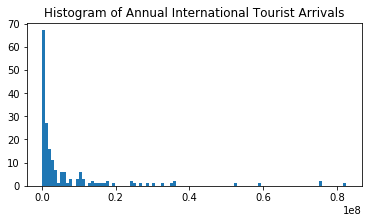

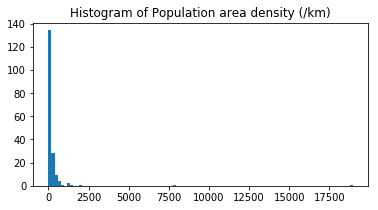

In [7]:
var_list = ['Annual International Tourist Arrivals',
            'Population area density (/km)']
n_bins = 100 # can decrease to get a wider bin (or vice versa)

for column_name in var_list:
    ax=plt.subplots(figsize=(6,3))
    # get data by column_name and display a histogram
    ax = plt.hist(static_df[column_name], bins=n_bins)
    title="Histogram of " + column_name
    plt.title(title, fontsize=12)
    plt.show()

Values above a certain maximum threshold for these variables will be clipped so that more information can be retained.

In [8]:
clip_cols = ['Annual International Tourist Arrivals',
            'Population area density (/km)']
clip_vals = [10000000, 500]

for col, val in zip(clip_cols, clip_vals):
    new_col = static_df[col].clip(upper=val)
    static_df[col] = new_col

Next, the up to date COVID-19 training dataset as well as the full SARS and Ebola data sets can be imported

In [9]:
covid_df = pd.read_csv('covid_19_ongoing.csv', header=0)
sars_df = pd.read_csv('sars_2003_complete_dataset_clean.csv', header=0)
ebola_df = pd.read_csv('ebola_2014_2016_clean.csv', header=0)

covid_df.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


Some values in the SARS and Ebola data sets need changing to match the COVID data

In [10]:
sars_df = sars_df.replace(['Taiwan, China', 'Republic of Ireland', 'Republic of Korea', 'Russian Federation', \
                           'United States', 'Viet Nam'],
                          ['Taiwan', 'Ireland', 'Korea, South', 'Russia', 'US', 'Vietnam'])
ebola_df = ebola_df.replace('United States of America', 'US')

The data sets for the different outbreaks need to be converted to cases and deaths time series. The SARS and Ebola data sets have gaps of days with missing data, where the cumulative totals of cases and deaths on those missing days will need to be interpolated.

In [11]:
def interpolation_calc(start_val, end_val, num_vals, heading):
    if (isinstance(start_val, (int, np.integer)) & isinstance(end_val, (int, np.integer))) or \
       (isinstance(start_val, (int, np.float)) & isinstance(end_val, (int, np.float))):
        new_val_set = np.linspace(start_val, end_val, num=num_vals, endpoint=True)[1:].round()
        return {heading: new_val_set}
    

def date_interpolate(df):
    # Go through rows in table keeping a record of the date
    # If the next date change is not the next day, insert the correct number of missing date values
    new_df = pd.DataFrame()
    

    for country in df.Country.unique():
        country_df = df.loc[df['Country'] == country]
        current_date = datetime.strptime(country_df['Date'].iloc[0], '%Y-%m-%d').date()
        for index, row in country_df.iterrows():
 
            date_str = row['Date']
            new_date = datetime.strptime(date_str, '%Y-%m-%d').date()
        
            if (new_date != current_date) & (new_date > current_date + timedelta(days=1)):
                #interpolate all values from previous date to new date

                num_missing = abs((new_date - current_date).days)
                current_date_df = country_df.loc[country_df['Date'] == str(current_date)]
                new_date_df = country_df.loc[country_df['Date'] == str(new_date)]    
                inter_df = current_date_df.append(new_date_df)

                inter_vals_dict = {}
                for name, data in inter_df.items():
                    if interpolation_calc(data.values[0], data.values[1], num_missing, name):
                        inter_vals_dict.update(interpolation_calc(data.values[0], data.values[1], num_missing+1, name))
                
                inter_vals_dict['Country'] = [country]*(num_missing)
                inter_vals_dict['Date'] = [current_date + timedelta(days=i+1) for i in range(num_missing)]
                inter_df = pd.DataFrame(inter_vals_dict)
                new_df = new_df.append(inter_df)
                
            else:
                new_df = new_df.append(row)
            
            current_date = copy(new_date) 
            
    return new_df
   


In [12]:
new_sars_df = date_interpolate(sars_df)
new_ebola_df = date_interpolate(ebola_df)

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Some of the countries in the COVID data set are broken down by province, and so the total of all a country's values on each date need to be added together.

In [13]:
def unite_provinces(df):
    
    new_df = pd.DataFrame()
    for country in df.Country_Region.unique():
        country_df = df.loc[df['Country_Region'] == country]
        current_date = datetime.strptime(country_df['Date'].iloc[0], '%Y-%m-%d').date()
        for date in country_df.Date.unique():
            country_date_df = country_df.loc[df['Date'] == date]
            if len(country_date_df['Date'].values) > 1:
                date_df = pd.DataFrame({'ConfirmedCases': [np.sum(country_date_df['ConfirmedCases'].values)],
                                        'Fatalities': [np.sum(country_date_df['Fatalities'].values)], 
                                        'Country_Region': [country_date_df['Country_Region'].values[0]],
                                        'Date': [country_date_df['Date'].values[0]]})

                new_df = new_df.append(date_df)
            else:
                new_df = new_df.append(country_date_df)
                                       
    return new_df                                   
    

In [14]:
new_covid_df = unite_provinces(covid_df)

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


The amended dataframes then need to be converted into the appropriate data input format, with target series beginning on the day of the first recorded case.

In [15]:
def df_to_dict(df, virus, data_type):
    
    country_headings = {'covid': 'Country_Region', 'sars': 'Country', 'ebola': 'Country'}
    data_headings = {'covid': {'cases': 'ConfirmedCases', 'mortalities': 'Fatalities'},
                     'sars': {'cases': 'Cumulative number of case(s)', 'mortalities': 'Number of deaths'},
                     'ebola': {'cases': 'No. of confirmed cases', 'mortalities': 'No. of confirmed deaths'}
                    }
    
    data_dict = {}
    for index, row in df.iterrows():
        if row[data_headings[virus][data_type]] > 0:
            if row[country_headings[virus]] in data_dict.keys():
                data_dict[row[country_headings[virus]]]['target'].append(row[data_headings[virus][data_type]])
            else:
                data_dict[row[country_headings[virus]]] = {
                                                           'start': str(row['Date']) + " 00:00:00",
                                                           'target': [row[data_headings[virus][data_type]]]
                                                          }

    return data_dict


In [16]:
covid_cases_dict = df_to_dict(new_covid_df, 'covid', 'cases')
sars_cases_dict = df_to_dict(new_sars_df, 'sars', 'cases')
ebola_cases_dict = df_to_dict(new_ebola_df, 'ebola', 'cases')

Each dictionary needs some entries removing which will not be useful when training the final model. For the SARS and Ebola data, this number is quite high and so it will be done using a function instead. Now will be the point to choose which series exactly will be used for training the models. These will be all of the national epidemics of COVID-19 (any number of cases), the Ebola outbreaks in Guinea and Sierra Leone, and the timelines of SARS in Singapore and China. The instances chosen from the Ebola and SARS outbreaks are the ones which best capture the full shape of the epidemic curve from start to finish. Many of the other countries only ever recorded a small handful of these cases so do not provide useful data.

In [17]:
del covid_cases_dict['Diamond Princess']
del covid_cases_dict['MS Zaandam']

In [18]:
def remove_countries(virus_dict, keep_list):
    countries_list = list(virus_dict.keys())
    for country in countries_list:
        if country not in keep_list:
            del virus_dict[country]
            
    return virus_dict

In [ ]:
ebola_keep_list = ['Guinea', 'Sierra Leone']
sars_keep_list = ['Singapore', 'China']

sars_cases_dict = remove_countries(sars_cases_dict, sars_keep_list)
ebola_cases_list = remove_countries(ebola_cases_dict, ebola_keep_list)

Now that the time series have been processed it is a good point for visualisations

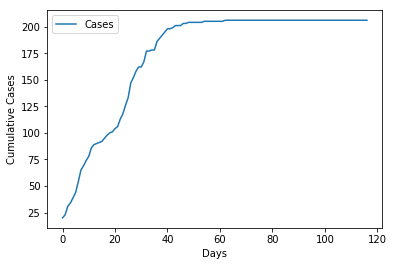

In [21]:
country = 'Singapore'

plt.xlabel('Days')
plt.ylabel('Cumulative Cases')
plt.plot(sars_cases_dict[country]['target'])
plt.legend(['Cases'])

**PCA**

Now the transmission factors will be translated into an appropriate number of principal components using SageMaker and MXNet. The transmission factors come from their own, separate data set and will need to be preprocessed further to be in a suitable input form.

In [22]:
features_list = static_df.columns.values
print(features_list)

['Country' 'Island (Y/N)' 'Landlocked (Y/N)'
 'Annual International Tourist Arrivals'
 'Average elevation above sea level (m)' 'Urban population percentage'
 'Air pollution Index' 'Population area density (/km)'
 'Average household size' 'Ethnic fractionalisation'
 'Linguistic fractionalisation' 'Religious fractionalisation'
 'GDP per Capita' 'Infant Mortality Rate (Deaths per 1000 Births)'
 'Annual Cigarette Consumption per Capita'
 'Proportion of Population Using Cannabis' 'Obesity Rate'
 'Corruption Perception Index' 'Crime Index' 'Water and Sanitation Rating']


The country names need to be changed to be the indexes of the columns

In [23]:
static_df.index=static_df['Country']
static_df = static_df.drop('Country', axis='columns')

Next, the column values need to be normalized between 0 and 1 for training. This will be done using the sklearn MinMaxScaler

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

for column, d_type in zip(static_df, static_df.dtypes):

    if d_type == 'int64' or d_type == 'float64':
        data = np.array(static_df[[column]])
        scaler.fit(data)
        new_data = scaler.transform(data)
        static_df[column] = new_data
        
static_scaled = static_df

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ec2-us

For the training job, it is necessary to import the Sagemaker and boto3 modules. Then a role, bucket name and session must be defined. The output of the PCA model will be stored in an S3 bucket at the path indicated by the prefix.

In [ ]:
import sagemaker
import boto3
from sagemaker import get_execution_role

session = sagemaker.Session()
role = get_execution_role()
bucket_name = session.default_bucket()
print('Role: {}, Bucket: {}'.format(role, bucket_name))

In [ ]:
prefix = 'static'
output_path='s3://{}/{}/'.format(bucket_name, prefix)
print('Output path: {}'.format(output_path))

The PCA object is instantiated using the role and output path defined above. As specified in the parameters, it will be trained on an ml.c4.xlarge instance, sufficiently powerful for the training process.

In [ ]:
from sagemaker import PCA

N_COMPONENTS=18

pca_obj = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path=output_path,
             num_components=N_COMPONENTS, 
             sagemaker_session=session)


In [35]:
# convert df to np array and convert to RecordSet format
train_array = static_scaled.values.astype('float32')
train_records = pca_obj.record_set(train_array)

Below, the training job is initiated

In [36]:
%%time
pca_obj.fit(train_records)

2020-04-23 10:50:44 Starting - Starting the training job...
2020-04-23 10:50:45 Starting - Launching requested ML instances......
2020-04-23 10:51:45 Starting - Preparing the instances for training...
2020-04-23 10:52:24 Downloading - Downloading input data...
2020-04-23 10:53:07 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/23/2020 10:53:23 INFO 139787782829888] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[04/23/2020 10:53:23 INFO 139787782829888] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'19', u'mini_batch_size': u'182', u'num_components':


2020-04-23 10:53:32 Uploading - Uploading generated training model
2020-04-23 10:53:32 Completed - Training job completed
Training seconds: 68
Billable seconds: 68
CPU times: user 392 ms, sys: 33.4 ms, total: 425 ms
Wall time: 3min 11s


In the cell below, the model is downloaded from S3 and unzipped. The training job name is manually copy and pasted from the SageMaker dashboard

In [ ]:
training_job_name='pca-2020-04-23-10-18-16-388'

prefix = 'static'
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)


# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

The parameters are then loaded using the MXNet module

In [ ]:
import mxnet as mx
pca_model_params = mx.ndarray.load('model_algo-1')

In [ ]:
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [40]:
def explained_variance(s, n_top_components):
    
    start_idx = N_COMPONENTS - n_top_components

    return np.sum(np.array(s[start_idx:] ** 2)) / np.sum(np.array(s ** 2))

Calculated in the cell below is the amount of variance explained using a specified number of components. In order to capture the desirable figure of 80% variance, 6 components are needed.

In [41]:
# test cell
n_top_components = 6 # select a value for the number of top components

# calculate the explained variance
exp_variance = explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0.8017985


Below, the chosen principal components are visualised using the seaborn module and a helper function

In [ ]:
import seaborn as sns

def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

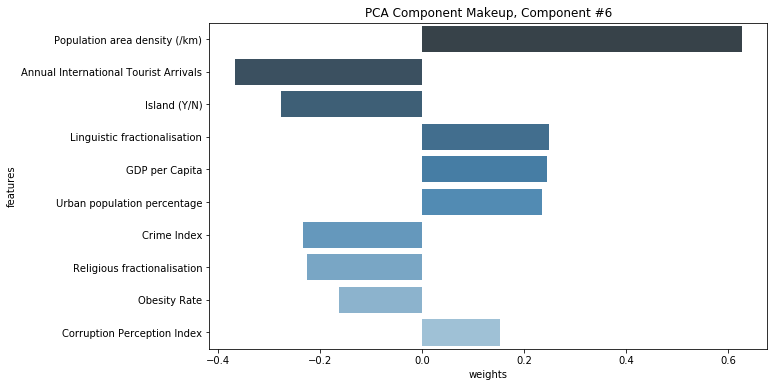

In [334]:
num=6
display_component(v, static_scaled.columns.values, component_num=num, n_weights=10)

Now an endpoint is deployed to create the values of principal components based on the country values, and this is saved to a local file for easier access later on.

In [44]:
%%time
pca_predictor = pca_obj.deploy(initial_instance_count=1, 
                              instance_type='ml.t2.medium')

---------------!CPU times: user 282 ms, sys: 13.8 ms, total: 295 ms
Wall time: 7min 32s


In [46]:
pca_features = pca_predictor.predict(train_array)

In [48]:
idx = 0
print(len(pca_features))
print(pca_features[idx])

182
label {
  key: "projection"
  value {
    float32_tensor {
      values: 0.17765265703201294
      values: 0.16912400722503662
      values: -0.09809082746505737
      values: 0.08858108520507812
      values: -0.06741790473461151
      values: -0.20249703526496887
      values: 0.10043339431285858
      values: 0.24907559156417847
      values: 0.03013916313648224
      values: -0.11977532505989075
      values: -0.2850041687488556
      values: 0.1384534239768982
      values: -0.17038407921791077
      values: 0.2216760814189911
      values: 0.2171558141708374
      values: -0.19341936707496643
      values: -0.2564607858657837
      values: 1.3371063470840454
    }
  }
}



In [53]:
def create_transformed_df(features_list, df, n_top_components):
    ''' Return a dataframe of data points with component features. 
        The dataframe should be indexed by State-County and contain component values.
        :param train_pca: A list of pca training data, returned by a PCA model.
        :param counties_scaled: A dataframe of normalized, original features.
        :param n_top_components: An integer, the number of top components to use.
        :return: A dataframe, indexed by State-County, with n_top_component values as columns.        
     '''
    df_transformed = pd.DataFrame()
    
    # create a dataframe of component features, indexed by State-County
    for data in features_list:
        components = data.label['projection'].float32_tensor.values
        df_transformed=df_transformed.append([list(components)])
        
    df_transformed.index = df.index
    
    start_idx = N_COMPONENTS - n_top_components
    df_transformed = df_transformed.iloc[:,start_idx:]
    
    return df_transformed.iloc[:, ::-1]


In [55]:
top_n = 6
static_transformed = create_transformed_df(pca_features, static_scaled, n_top_components=top_n)
static_transformed.columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']

static_transformed.head()

,x1,x2,x3,x4,x5,x6
Country,,,,,,
Afghanistan,1.337106,-0.256461,-0.193419,0.217156,0.221676,-0.170384
Albania,-0.292520,-0.059736,0.237031,0.309987,0.152504,-0.081050
Algeria,-0.028620,-0.016887,0.440567,0.498882,-0.102744,0.047110
Andorra,-0.199266,-1.036531,-0.304143,-0.230978,-0.447893,0.381868
Angola,0.903921,0.357231,0.434472,-0.207126,-0.134273,0.083259


In [56]:
session.delete_endpoint(pca_predictor.endpoint)

In [57]:
static_transformed.to_csv('pca_features.csv')

**Time Series**

Using the static features created with PCA, as well as the temporal variables, time series need to be made for each national outbreak to use as dynamic feature arrays when training the model. The static features will be done first, followed by the temporal ones.

In [25]:
static_transformed = pd.read_csv('pca_features.csv', index_col='Country')

In [26]:
static_transformed.head()

,x1,x2,x3,x4,x5,x6
Country,,,,,,
Afghanistan,1.337106,-0.256461,-0.193419,0.217156,0.221676,-0.170384
Albania,-0.292520,-0.059736,0.237031,0.309987,0.152504,-0.081050
Algeria,-0.028620,-0.016887,0.440567,0.498882,-0.102744,0.047110
Andorra,-0.199266,-1.036531,-0.304143,-0.230978,-0.447893,0.381868
Angola,0.903921,0.357231,0.434472,-0.207126,-0.134273,0.083259


**Static**

The static time series for each epidemic is made in the next couple of cells. These will be of varying length, beginning on the first day on which each country recorded its first case.

In [41]:
def convert_static_values_for_series(df, virus_dict):
    
    static_series_dict = {}
    for country in virus_dict.keys():
        static_series_dict[country] = {}
        for feature in df.columns:
            print(virus_dict)
            static_series_dict[country][feature] = [df.loc[country, feature]]*len(virus_dict[country]['target'])
    
    return static_series_dict

In [42]:
covid_static_series_dict = convert_static_values_for_series(static_transformed, covid_cases_dict)
sars_static_series_dict = convert_static_values_for_series(static_transformed, sars_cases_dict)
ebola_static_series_dict = convert_static_values_for_series(static_transformed, ebola_cases_dict)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



**Temporal**

Now the same needs to be done for the temporal values. It is a little more complicated for these as they do not keep constant values throughout the entire series, but change on dates specified in separate columnms. Functions for processing this information and outputting data in the correct format are written below. Also, the row indexes need to be changed to be the country names again.


In [27]:
time_df.index=time_df['Country.1']
time_df = time_df.drop('Country.1', axis='columns')

In [30]:
month_dict = {'01': 'Jan', '02': 'Feb', '03': 'Mar', '04': 'Apr', '05': 'Mar', '06': 'Jun',
              '07': 'Jul', '08': 'Aug', '09': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'}

def initialize_country_series_dict(series_dict, virus_dict, country):
    
    date_str = virus_dict[country]['start']   
    current_date = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S').date()
        
    series_dict[country] = {}
    series_dict[country]['start'] = date_str
    series_dict[country]['target'] = []
    
    return series_dict[country], current_date
    

def convert_temp_values_for_series(df, virus_dict):
    

    temp_series_dict = {}
    for country in virus_dict.keys():
        
        temp_series_dict[country], current_date = initialize_country_series_dict(temp_series_dict, virus_dict, country)
        
        for day in range(len(virus_dict[country]['target'])):

            month_tkr = str(current_date.month)
            month_tkr = '0' + month_tkr if len(month_tkr) < 2 else month_tkr
            
            temp_series_dict[country]['target'].append(time_df.loc[country, 'Avg {} Temp C' \
                                                                   .format(month_dict[month_tkr])]) 
        
            current_date += timedelta(days=1)
                
        
    return temp_series_dict

In [31]:
covid_temp_series_dict = convert_temp_values_for_series(time_df, covid_cases_dict)
sars_temp_series_dict = convert_temp_values_for_series(time_df, sars_cases_dict)
ebola_temp_series_dict = convert_temp_values_for_series(time_df, ebola_cases_dict)

Now the same process needs to be done for the lockdowns.

In [32]:
def convert_lockdown_values_for_series(df, virus_dict, covid=True):
    

    ld_series_dict = {} 
    for country in virus_dict.keys():
        
        ld_series_dict[country], current_date = initialize_country_series_dict(ld_series_dict, virus_dict, country)
        
        lockdown = 0
        for day in range(len(virus_dict[country]['target'])):
            
            if time_df.loc[country, 'Lockdown 1 Start'] == str(current_date):
                lockdown = 1
            elif time_df.loc[country, 'Lockdown 2 Start'] == str(current_date):    
                lockdown = 2
            elif time_df.loc[country, 'Lockdown 3 Start'] == str(current_date):    
                lockdown = 3    
                    
            if covid:        
                if lockdown == 0:
                    ld_series_dict[country]['target'].append(0)
                else:
                    ld_series_dict[country]['target'].append(time_df.loc[country, 'Pop. Proportion {}'.format(lockdown)])
                    if time_df.loc[country, 'Lockdown {} End'.format(lockdown)] == str(current_date):
                        lockdown = 0
            else:
                ld_series_dict[country]['target'].append(1)

        
            current_date += timedelta(days=1)
            
    return ld_series_dict        

In [33]:
covid_ld_series_dict = convert_lockdown_values_for_series(time_df, covid_cases_dict)
sars_ld_series_dict = convert_lockdown_values_for_series(time_df, sars_cases_dict, covid=False)
ebola_ld_series_dict = convert_lockdown_values_for_series(time_df, ebola_cases_dict, covid=False)

**Normalization** 

Finally, before training, the cases and mortalities values will be normalized by country to take on a value of instances per million people. This step is taken in order to make the proportional lockdown values more relevant, as well as make the series more consistent with each other. 

In [34]:
def normalize_dict(series_dict, df):
    
    normalized_dict = {}
    for country in series_dict:
        normalized_dict[country] = {}
        normalized_dict[country]['start'] = series_dict[country]['start']
        normalized_dict[country]['target'] = []
        
        num_millions = df.loc[country, 'Population'] / 1000000
        for value in series_dict[country]['target']:
            value /= num_millions
            normalized_dict[country]['target'].append(value)
            
    return normalized_dict      

In [35]:
norm_covid_cases_dict = normalize_dict(covid_cases_dict, time_df)
norm_sars_cases_dict = normalize_dict(sars_cases_dict, time_df)
norm_ebola_cases_dict = normalize_dict(ebola_cases_dict, time_df)

**Concatenation** 

Now records for each epidemic can be brought together into a single json object, with the main time series of virus cases as the 'target array', and each of the other arrays - e.g. pca features, lockdown series added to the 'dynamic_feat' array. A single json object will be created for each national epidemic, so all countries will have one associated object apart from the four countries with a second separate virus outbreak included. At this point, two separate files will be made for training and for testing.

In [44]:
def series_to_json_obj(country, main_series_dict, static_dict, temp_dict, ld_dict, train, prediction_length):

    end_val = -prediction_length if train == True else None
    json_obj = {}
    json_obj['start'] = main_series_dict[country]['start']
    json_obj['target'] = main_series_dict[country]['target'][:end_val]
    json_obj['dynamic_feat'] = []
    
    for component in static_dict[country]:
        json_obj['dynamic_feat'].append(static_dict[country][component][:end_val])
    json_obj['dynamic_feat'].append(temp_dict[country]['target'][:end_val])
    json_obj['dynamic_feat'].append(ld_dict[country]['target'][:end_val])
    
    return json_obj

In [45]:
import json

def write_cases_json_dataset(filename, df, train, prediction_length): 
    with open(filename, 'wb') as f:
        # for each of our times series, there is one JSON line
        for country in df['Country']:
            json_line = json.dumps(series_to_json_obj(country,
                                                      norm_covid_cases_dict, 
                                                      covid_static_series_dict, 
                                                      covid_temp_series_dict, 
                                                      covid_ld_series_dict, 
                                                      train,
                                                      prediction_length)) + '\n'
            if country in norm_sars_cases_dict:
                json_line = json.dumps(series_to_json_obj(country,
                                                          norm_sars_cases_dict, 
                                                          sars_static_series_dict, 
                                                          sars_temp_series_dict, 
                                                          sars_ld_series_dict, 
                                                          train,
                                                          prediction_length)) + '\n'
            if country in norm_ebola_cases_dict:
                json_line = json.dumps(series_to_json_obj(country,
                                                          norm_ebola_cases_dict, 
                                                          ebola_static_series_dict, 
                                                          ebola_temp_series_dict, 
                                                          ebola_ld_series_dict, 
                                                          train,
                                                          prediction_length)) + '\n'    
            json_line = json_line.encode('utf-8')
            f.write(json_line)
    print(filename + ' saved.')

In [38]:
# save this data to a local directory
data_dir = 'json_data'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [46]:
# directories to save train/test data
train_path = os.path.join(data_dir, 'train.json')
test_path = os.path.join(data_dir, 'test.json')

prediction_length = 7

# write train/test JSON files
write_cases_json_dataset(train_path, df, train=True, prediction_length=prediction_length)  
write_cases_json_dataset(test_path, df, train=False, prediction_length=None)        

json_data/train.json saved.
json_data/test.json saved.


---
## Uploading Data to S3


In [58]:
# suggested that you set prefixes for directories in S3
prefix = 'sagemaker/forecasting'
path_train = '{}/{}'.format(prefix, 'train.json')
path_test = '{}/{}'.format(prefix, 'test.json')

# upload data to S3, and save unique locations
boto3.Session().resource('s3').Bucket(bucket_name).upload_file('json_data/train.json', path_train)
boto3.Session().resource('s3').Bucket(bucket_name).upload_file('json_data/test.json', path_test)

In [59]:
train_path = "s3://sagemaker-eu-west-1-622694881594/sagemaker/forecasting/train.json"
test_path = "s3://sagemaker-eu-west-1-622694881594/sagemaker/forecasting/test.json"

print('Training data is stored in: '+ train_path)
print('Test data is stored in: '+ test_path)

Training data is stored in: s3://sagemaker-eu-west-1-622694881594/sagemaker/forecasting/train.json
Test data is stored in: s3://sagemaker-eu-west-1-622694881594/sagemaker/forecasting/test.json


---
# Training and Deploying a DeepAR Estimator

The estimator object is instantiated with an 'ml.c4.xlarge' instance, and uses the current role and session defined previously for the training of the PCA model. Here, the hyperparameters are also set for the training process, with the frequency the only unchangeable variable indicating that the time series is daily.

In [49]:
from sagemaker.amazon.amazon_estimator import get_image_uri

image_name = get_image_uri(boto3.Session().region_name, # get the region
                           'forecasting-deepar') # specify image

In [54]:
from sagemaker.estimator import Estimator
sagemaker_session = sagemaker.Session()

# instantiate a DeepAR estimator
estimator = Estimator(image_name,
                      role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      sagemaker_session=sagemaker_session)

In [55]:
freq='D'
context_length=7
prediction_length=7
hyperparameters = {
    "epochs": "50",
    "time_freq": freq,
    "prediction_length": str(prediction_length),
    "context_length": str(context_length),
    "num_cells": "50",
    "num_dynamic_feat": "auto",
    "num_layers": "3",
    "mini_batch_size": "128",
    "learning_rate": "0.001",
    "early_stopping_patience": "10"
}

In [56]:
estimator.set_hyperparameters(**hyperparameters)

In [60]:
%%time
# train and test channels
data_channels = {
    "train": train_path,
    "test": test_path
}

# fit the estimator
estimator.fit(inputs=data_channels)

2020-04-26 00:01:58 Starting - Starting the training job...
2020-04-26 00:01:59 Starting - Launching requested ML instances......
2020-04-26 00:02:59 Starting - Preparing the instances for training......
2020-04-26 00:04:23 Downloading - Downloading input data
2020-04-26 00:04:23 Training - Downloading the training image..Arguments: train
[04/26/2020 00:04:39 INFO 140482584008512] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[04/26/2020 00:04:39 I


2020-04-26 00:04:36 Training - Training image download completed. Training in progress.[04/26/2020 00:04:43 INFO 140482584008512] Epoch[2] Batch[10] avg_epoch_loss=3.612047
[04/26/2020 00:04:43 INFO 140482584008512] #quality_metric: host=algo-1, epoch=2, batch=10 train loss <loss>=3.6983812809
[04/26/2020 00:04:43 INFO 140482584008512] Epoch[2] Batch [10]#011Speed: 1491.81 samples/sec#011loss=3.698381
[04/26/2020 00:04:43 INFO 140482584008512] processed a total of 1302 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1209.2158794403076, "sum": 1209.2158794403076, "min": 1209.2158794403076}}, "EndTime": 1587859483.915365, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1587859482.70609}

[04/26/2020 00:04:43 INFO 140482584008512] #throughput_metric: host=algo-1, train throughput=1076.53575012 records/second
[04/26/2020 00:04:43 INFO 140482584008512] #progress_metric: host=algo-1, completed 6 % of epochs
[04/26/2020 00:

[04/26/2020 00:04:53 INFO 140482584008512] Epoch[10] Batch[10] avg_epoch_loss=2.852017
[04/26/2020 00:04:53 INFO 140482584008512] #quality_metric: host=algo-1, epoch=10, batch=10 train loss <loss>=3.35265612602
[04/26/2020 00:04:53 INFO 140482584008512] Epoch[10] Batch [10]#011Speed: 1699.61 samples/sec#011loss=3.352656
[04/26/2020 00:04:53 INFO 140482584008512] processed a total of 1317 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1135.7240676879883, "sum": 1135.7240676879883, "min": 1135.7240676879883}}, "EndTime": 1587859493.713545, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1587859492.577754}

[04/26/2020 00:04:53 INFO 140482584008512] #throughput_metric: host=algo-1, train throughput=1159.48827256 records/second
[04/26/2020 00:04:53 INFO 140482584008512] #progress_metric: host=algo-1, completed 22 % of epochs
[04/26/2020 00:04:53 INFO 140482584008512] #quality_metric: host=algo-1, epoch=10, train loss <lo

[04/26/2020 00:05:03 INFO 140482584008512] Epoch[19] Batch[5] avg_epoch_loss=2.147323
[04/26/2020 00:05:03 INFO 140482584008512] #quality_metric: host=algo-1, epoch=19, batch=5 train loss <loss>=2.14732301235
[04/26/2020 00:05:03 INFO 140482584008512] Epoch[19] Batch [5]#011Speed: 1976.87 samples/sec#011loss=2.147323
[04/26/2020 00:05:04 INFO 140482584008512] Epoch[19] Batch[10] avg_epoch_loss=2.356387
[04/26/2020 00:05:04 INFO 140482584008512] #quality_metric: host=algo-1, epoch=19, batch=10 train loss <loss>=2.6072637558
[04/26/2020 00:05:04 INFO 140482584008512] Epoch[19] Batch [10]#011Speed: 1716.78 samples/sec#011loss=2.607264
[04/26/2020 00:05:04 INFO 140482584008512] processed a total of 1364 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1142.1170234680176, "sum": 1142.1170234680176, "min": 1142.1170234680176}}, "EndTime": 1587859504.199589, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1587859503.056997}




2020-04-26 00:05:23 Uploading - Uploading generated training model
2020-04-26 00:05:23 Completed - Training job completed
#metrics {"Metrics": {"model.score.time": {"count": 1, "max": 3556.7519664764404, "sum": 3556.7519664764404, "min": 3556.7519664764404}}, "EndTime": 1587859514.940363, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1587859511.383722}

[04/26/2020 00:05:14 INFO 140482584008512] #test_score (algo-1, RMSE): 250.595610454
[04/26/2020 00:05:14 INFO 140482584008512] #test_score (algo-1, mean_absolute_QuantileLoss): 73419.17751071586
[04/26/2020 00:05:14 INFO 140482584008512] #test_score (algo-1, mean_wQuantileLoss): 0.09719455794493276
[04/26/2020 00:05:14 INFO 140482584008512] #test_score (algo-1, wQuantileLoss[0.1]): 0.056132048950950315
[04/26/2020 00:05:14 INFO 140482584008512] #test_score (algo-1, wQuantileLoss[0.2]): 0.08277083965339685
[04/26/2020 00:05:14 INFO 140482584008512] #test_score (algo-1, wQuantileLoss[

The model is then deployed below so that it can be used to make predictions

In [61]:
%%time

# create a predictor
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    content_type="application/json" # specify that it will accept/produce JSON
)

-----------------!CPU times: user 288 ms, sys: 12.1 ms, total: 300 ms
Wall time: 8min 32s


The following cells are used to create suitable inputs for the predictor from the dictionaries of series created earlier on. The inputs are passed to the predictor, which returns an encoded result. This needs to be decoded before it can be used to make a prediction. 

In [69]:
def series_to_prediction_json_obj(country, main_series_dict, static_dict, temp_dict, ld_dict, train, prediction_length):

    end_val = -prediction_length if train == True else None
    json_obj = {}
    json_obj['start'] = main_series_dict[country]['start']
    json_obj['target'] = main_series_dict[country]['target'][:end_val]
    json_obj['dynamic_feat'] = []
    
    for component in static_dict[country]:
        json_obj['dynamic_feat'].append(static_dict[country][component])
    json_obj['dynamic_feat'].append(temp_dict[country]['target'])
    json_obj['dynamic_feat'].append(ld_dict[country]['target'])
    
    return json_obj

In [79]:
def covid_json_predictor_input(df, train, prediction_length, num_samples=1000, quantiles=['0.1', '0.5', '0.9']):
    
    instances = []
    for country in df['Country']:
        instances.append(series_to_prediction_json_obj(country,
                                        norm_covid_cases_dict, 
                                        covid_static_series_dict, 
                                        covid_temp_series_dict, 
                                        covid_ld_series_dict, 
                                        train,
                                        prediction_length))

    # specify the output quantiles and samples
    configuration = {"num_samples": num_samples, 
                     "output_types": ["quantiles"], 
                     "quantiles": quantiles}

    request_data = {"instances": instances, 
                    "configuration": configuration}
    
    json_request = json.dumps(request_data).encode('utf-8')
    
    return json_request

In [84]:
json_input_ts = covid_json_predictor_input(df, train=True, prediction_length=prediction_length)
json_prediction = predictor.predict(json_input_ts)

In [72]:
def decode_prediction(prediction, encoding='utf-8'):
    '''Accepts a JSON prediction and returns a list of prediction data.
    '''
    prediction_data = json.loads(prediction.decode(encoding))
    prediction_list = []
    for k in range(len(prediction_data['predictions'])):
        prediction_list.append(pd.DataFrame(data=prediction_data['predictions'][k]['quantiles']))
    return prediction_list


In [85]:
prediction_list = decode_prediction(json_prediction)

**Visualisation**

The function below helps to display the prediction based on the mean, upper and lower bounds of of a sampling process (with the interior of the bounds highlighted) and its target value

In [75]:
def display_quantiles(prediction_list, target_ts=None):
    # show predictions for all input ts
    for k in range(len(prediction_list)):
        plt.figure(figsize=(12,6))
        # get the target month of data
        if target_ts is not None:
            target = target_ts[k][-prediction_length:]
            plt.plot(range(len(target)), target, label='target')
        # get the quantile values at 10 and 90%
        p10 = prediction_list[k]['0.1']
        p90 = prediction_list[k]['0.9']
        # fill the 80% confidence interval
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        # plot the median prediction line
        prediction_list[k]['0.5'].plot(label='prediction median')
        plt.legend()
        print
        plt.show()

In [82]:
target_series = []
for country in norm_covid_cases_dict:
    target_series.append(pd.Series(norm_covid_cases_dict[country]['target']))
       

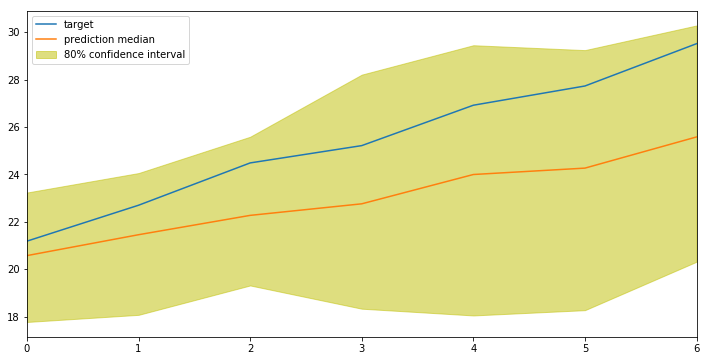

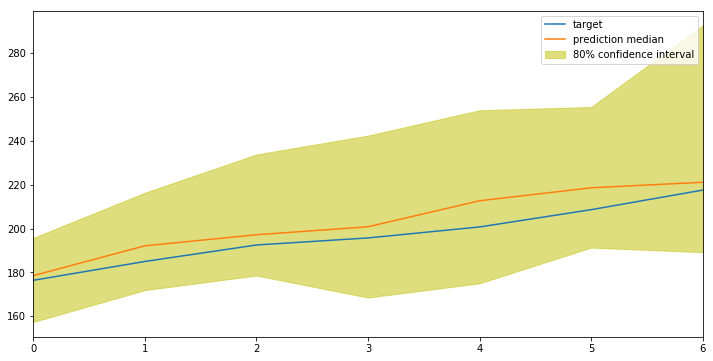

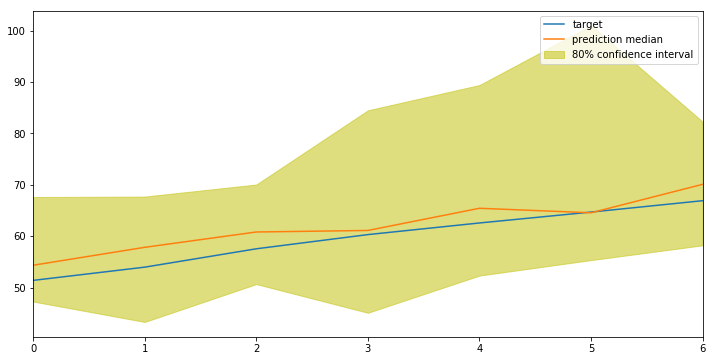

In [77]:
display_quantiles(prediction_list[:3], target_series[:3])

**Model Accuracy**

Now, to calculate the accuracy, all of the target values within the confidence bounds are added, and this sum is divided by the length of the target array. This value is then averaged across time series predictions for all countries to obtain the overall model accuracy.

In [86]:
acc_list = []
acc_tot = 0

for targets, predictions in zip(target_series, prediction_list):
    ctr = 0
    for target_value, lower_bound, upper_bound in zip(targets[-prediction_length:], predictions['0.1'], predictions['0.9']):

        if (target_value >= lower_bound) & (target_value <= upper_bound):
            
            ctr += 1
            
    acc = ctr / prediction_length
    acc_tot += acc
    acc_list.append(acc)
    
acc_tot = acc_tot / len(target_series) 

print('Overall accuracy: {}'.format(acc_tot))

Overall accuracy: 0.7794348508634221


**Impact Values**

This final section calculates the impacts of each factor on the prediction. It works by finding the lowest value of each principal component (the most negative) and use this value for all countries as a way of nullifying the effect that countries strongly correlated to a particular component have on the prediction.

In [87]:
def nullified_factor_dict(factor_dict, factor_type):
    new_dict = dict(factor_dict)
    for country in factor_dict:
        new_dict[country][factor_type] = [np.amin(static_transformed[factor_type])] * len(factor_dict[country][factor_type])

    return new_dict    

In [89]:
def covid_json_nullified_factor_input(df, factor, train, prediction_length, num_samples=1000, quantiles=['0.1', '0.5', '0.9']):
    
    instances = []
    null_dict = nullified_factor_dict(covid_static_series_dict, factor)
    
    for country in df['Country']:
        #print('Country: {}, Factor: {}, Factor Dict: {}'.format(country, factor, null_dict[country][factor]))
        instances.append(series_to_prediction_json_obj(country,
                                        norm_covid_cases_dict, 
                                        null_dict, 
                                        covid_temp_series_dict, 
                                        covid_ld_series_dict, 
                                        train=True,
                                        prediction_length=prediction_length))

    # specify the output quantiles and samples
    configuration = {"num_samples": num_samples, 
                     "output_types": ["quantiles"], 
                     "quantiles": quantiles}

    request_data = {"instances": instances, 
                    "configuration": configuration}

    json_request = json.dumps(request_data).encode('utf-8')
    
    return json_request

In [90]:
def impact_calc(prediction_list, prediction_list_null):

    imp_tot = 0    
    for predictions, predictions_null in zip(prediction_list, prediction_list_null):
        ctr = 0
        for orig_mean, new_mean in zip(predictions['0.5'], predictions_null['0.5']):
            ctr += (new_mean - orig_mean)
            
        impact = ctr / prediction_length
        imp_tot += impact
    
    return imp_tot / len(prediction_list)

In [91]:
#1000 samples per prediction
json_input_ts = covid_json_predictor_input(df, train=True, prediction_length=prediction_length)
orig_json_prediction = predictor.predict(json_input_ts)
orig_prediction_list = decode_prediction(orig_json_prediction)

for factor in static_transformed.columns:
    json_input_ts_null = covid_json_nullified_factor_input(df, factor, True, prediction_length)
    json_prediction_null = predictor.predict(json_input_ts_null)
    null_prediction_list = decode_prediction(json_prediction_null)
    
    impact = impact_calc(orig_prediction_list, null_prediction_list)
    print('Impact of {}: {}'.format(factor, impact))
    

Impact of x1: 13.18993179804216
Impact of x2: 18.652826071862716
Impact of x3: 18.173242621696154
Impact of x4: 43.443445305527796
Impact of x5: 61.392697603726624
Impact of x6: 28.140856388458708


In [558]:
covid_static_series_dict = convert_static_values_for_series(static_transformed, covid_cases_dict)
sars_static_series_dict = convert_static_values_for_series(static_transformed, sars_cases_dict)
ebola_static_series_dict = convert_static_values_for_series(static_transformed, ebola_cases_dict)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Now the same approach is taken for the temperature and lockdown time series

In [92]:
def nullified_series_dict(series_dict):
    new_dict = dict(series_dict)
    min_val = np.amin([np.amin(series_dict[country]['target']) for country in series_dict])
    for country in series_dict:
        new_dict[country]['target'] = [min_val] * len(series_dict[country]['target'])

    return new_dict 

**Temperature Impact**

In [93]:
def covid_json_nullified_temp_input(df, train, prediction_length, num_samples=1000, quantiles=['0.1', '0.5', '0.9']):
    
    instances = []
    #null_dict = nullified_factor_dict(covid_static_series_dict, factor)
    null_dict = nullified_series_dict(covid_temp_series_dict)
    
    for country in df['Country']:
        #print('Country: {}, Factor: {}, Factor Dict: {}'.format(country, factor, null_dict[country][factor]))
        instances.append(series_to_prediction_json_obj(country,
                                        norm_covid_cases_dict, 
                                        covid_static_series_dict, 
                                        null_dict, 
                                        covid_ld_series_dict, 
                                        train=True,
                                        prediction_length=prediction_length))

    # specify the output quantiles and samples
    configuration = {"num_samples": num_samples, 
                     "output_types": ["quantiles"], 
                     "quantiles": quantiles}

    request_data = {"instances": instances, 
                    "configuration": configuration}

    json_request = json.dumps(request_data).encode('utf-8')
    
    
    return json_request

In [94]:
#1000 samples per prediction
json_input_ts = covid_json_predictor_input(df, train=True, prediction_length=prediction_length)
orig_json_prediction = predictor.predict(json_input_ts)
orig_prediction_list = decode_prediction(orig_json_prediction)

json_input_ts_null = covid_json_nullified_temp_input(df, True, prediction_length)
json_prediction_null = predictor.predict(json_input_ts_null)
null_prediction_list = decode_prediction(json_prediction_null)
    
impact = impact_calc(orig_prediction_list, null_prediction_list)
print('Impact of temperature: {}'.format(impact))

Impact of temperature: 94.60871552908617


**Lockdown Impact**

In [95]:
def covid_json_nullified_ld_input(df, train, prediction_length, num_samples=1000, quantiles=['0.1', '0.5', '0.9']):
    
    instances = []
    #null_dict = nullified_factor_dict(covid_static_series_dict, factor)
    null_dict = nullified_series_dict(covid_ld_series_dict)
    
    for country in df['Country']:
        #print('Country: {}, Factor: {}, Factor Dict: {}'.format(country, factor, null_dict[country][factor]))
        instances.append(series_to_prediction_json_obj(country,
                                        norm_covid_cases_dict, 
                                        covid_static_series_dict, 
                                        covid_temp_series_dict, 
                                        null_dict, 
                                        train=True,
                                        prediction_length=prediction_length))

    # specify the output quantiles and samples
    configuration = {"num_samples": num_samples, 
                     "output_types": ["quantiles"], 
                     "quantiles": quantiles}

    request_data = {"instances": instances, 
                    "configuration": configuration}

    json_request = json.dumps(request_data).encode('utf-8')
    
    
    return json_request

In [96]:
#1000 samples per prediction
json_input_ts = covid_json_predictor_input(df, train=True, prediction_length=prediction_length)
orig_json_prediction = predictor.predict(json_input_ts)
orig_prediction_list = decode_prediction(orig_json_prediction)

json_input_ts_null = covid_json_nullified_ld_input(df, True, prediction_length)
json_prediction_null = predictor.predict(json_input_ts_null)
null_prediction_list = decode_prediction(json_prediction_null)
    
impact = impact_calc(orig_prediction_list, null_prediction_list)
print('Impact of lockdown: {}'.format(impact))

Impact of lockdown: -10.112365873468834
